In [ ]:
!unzip 'test.zip'
!unzip 'train.zip'

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/d

In [ ]:
!pip install keras

In [ ]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.applications import vgg16
from keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as k
import os
from random import shuffle
from glob import glob

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

print(tf.__version__)
print(tf.executing_eagerly())

2.15.0
True


In [ ]:
train_files_zip = glob('train/*.jpg')
test_files_zip = glob('test/*.jpg')

In [ ]:
IMG_SIZE = (224, 224)

def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return tf.keras.applications.mobilenet_v2.preprocess_input(img) # предобработка для MNv2

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield (np.array([load_image(path)]), )

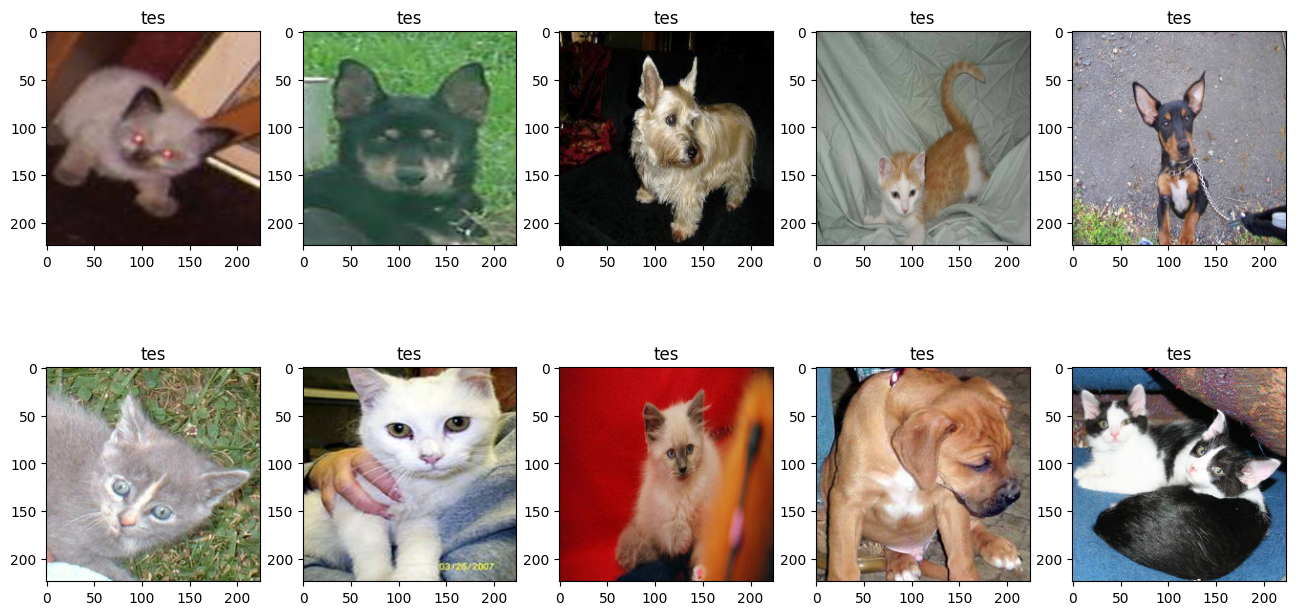

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(test_files_zip[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path[:3])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)
plt.show()

In [ ]:
train,validation = train_test_split(df,test_size=0.2,random_state=42)
train = train.reset_index(drop=True)
validation  = validation.reset_index(drop=True)
train.head()

,Image,Category
0,cat.4982.jpg,cat
1,cat.3208.jpg,cat
2,dog.3183.jpg,dog
3,cat.5874.jpg,cat
4,cat.1228.jpg,cat


вариант без аугментации

In [ ]:
MNv2_model = MobileNetV2(
                        input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False
                        )
MNv2_model.trainable = False

In [ ]:
MNv2_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

## Добавляем полносвязный слой

In [ ]:
model = tf.keras.Sequential([
    MNv2_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

## Компилируем модель и запускаем обучение

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [ ]:
# load_image(train_files_zip[0])

In [ ]:
val_samples = 1000  # число изображений в валидационной выборке

shuffle(train_files_zip)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files_zip[:val_samples], val_samples))
train_data = fit_generator(train_files_zip[val_samples:])

In [ ]:
batch_size = 64

history = model.fit(
                    train_data,
                    steps_per_epoch  = 10,
                    validation_data  = validation_data,
                    epochs = 20
    )

Epoch 1/20
10/10 [==============================] - 6s 690ms/step - loss: 0.9717 - accuracy: 0.9688 - val_loss: 0.2956 - val_accuracy: 0.9810
Epoch 2/20
10/10 [==============================] - 3s 323ms/step - loss: 0.2565 - accuracy: 0.9844 - val_loss: 0.2428 - val_accuracy: 0.9810
Epoch 3/20
10/10 [==============================] - 4s 467ms/step - loss: 0.1401 - accuracy: 0.9781 - val_loss: 0.2824 - val_accuracy: 0.9810
Epoch 4/20
10/10 [==============================] - 3s 276ms/step - loss: 0.4154 - accuracy: 0.9719 - val_loss: 0.2190 - val_accuracy: 0.9870
Epoch 5/20
10/10 [==============================] - 4s 437ms/step - loss: 0.3074 - accuracy: 0.9875 - val_loss: 0.2809 - val_accuracy: 0.9830
Epoch 6/20
10/10 [==============================] - 2s 224ms/step - loss: 0.7278 - accuracy: 0.9656 - val_loss: 0.1382 - val_accuracy: 0.9860
Epoch 7/20
10/10 [==============================] - 4s 451ms/step - loss: 0.5254 - accuracy: 0.9688 - val_loss: 0.1429 - val_accuracy: 0.9830
Epoch 

In [ ]:
test_pred = model.predict(
    predict_generator(test_files_zip), steps=len(test_files_zip))

12500/12500 [==============================] - 203s 16ms/step


In [ ]:
test_data = pd.DataFrame({"filename": test_files_zip})
test_data['label'] = 'unknown'
# test_data

In [ ]:
test_prediction_argmax = test_pred.round(0)

y_test_pred = test_prediction_argmax

test_data['label'] = y_test_pred

# mapping
label_mapping = {0: 'cat', 1: 'dog'}
test_data['label'] = test_data['label'].map(label_mapping)
test_data.head(10)

,filename,label
0,test/9579.jpg,cat
1,test/12225.jpg,dog
2,test/9296.jpg,dog
3,test/514.jpg,cat
4,test/9253.jpg,dog
5,test/4785.jpg,cat
6,test/3971.jpg,cat
7,test/10675.jpg,cat
8,test/11344.jpg,dog
9,test/4087.jpg,cat


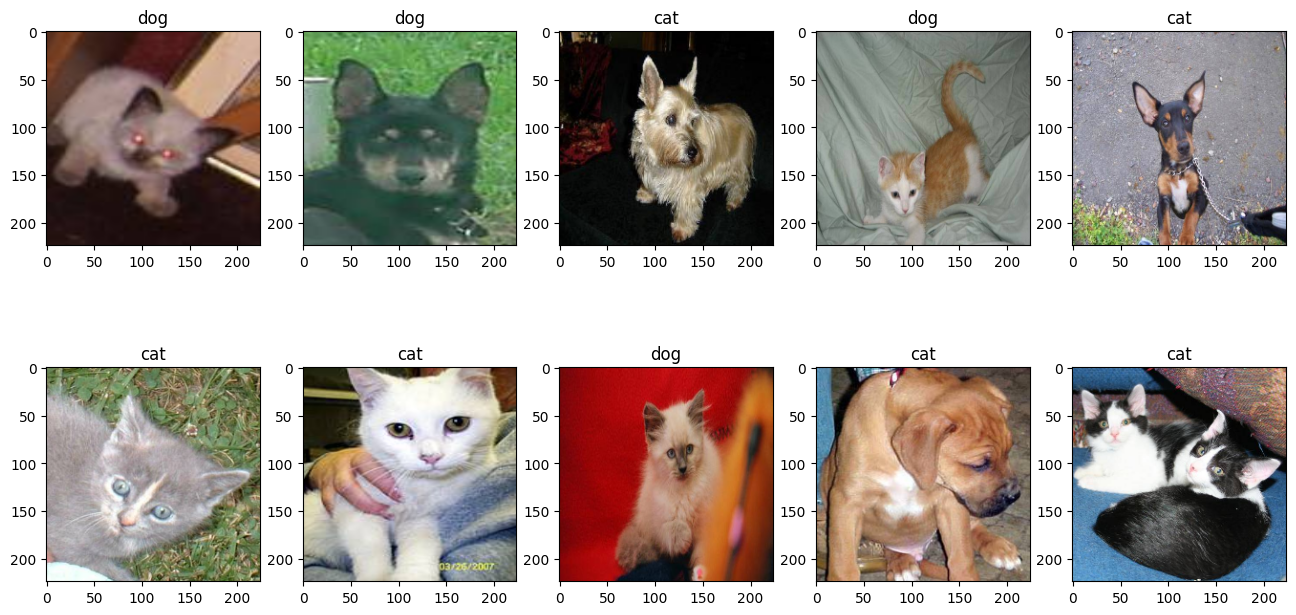

In [ ]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(test_data['filename'][:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title(test_data['label'][i])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)
plt.show()

In [ ]:
submission = pd.read_csv('sample_submission.csv',index_col='id')

submission['label'] = y_test_pred

submission.to_csv('submission_MNv2.csv',index=True)

**-------------------------------------------------------------------**